<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson10_coursework/PyTorch_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание по итогам курса:**

- (упрощенное/для тех, у кого нет вебкамеры)
    1. Нужно написать приложение, которое будет получать на вход *изображение*.
    2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
    3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

- (более сложное)
    1. Нужно написать приложение, которое будет считывать и выводить кадры с *веб-камеры*.
    2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
    3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать. 
____________________
- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
- Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

Будем делать задание с веб-камерой.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
import pandas as pd
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from itertools import islice


import numpy as np
import matplotlib.pyplot as plt

import time
import cv2 # Image handling library
from glob import glob
import sys, os
from PIL import Image

## Загрузка данных

In [2]:
! mkdir ~/.kaggle
from google.colab import files

files.upload()

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download gti-upm/leapgestrecog
! unzip -q '/content/leapgestrecog.zip'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Saving kaggle.json to kaggle.json
 99% 2.12G/2.13G [00:14<00:00, 189MB/s]
100% 2.13G/2.13G [00:14<00:00, 153MB/s]


device(type='cuda', index=0)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip -q /content/drive/MyDrive/PyTorch_coursework/Hand_Gesture_Recognition_Database.zip

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device

Пройдёмся по директориям. Добавим списки фотографий и лейблов.

In [4]:
images = []
labels = []
label_names = []

for i in range(0, 10):
    for j in os.listdir('/content/leapGestRecog/0' + str(i) + '/'):      
      if not j.startswith('.'):
        for k in os.listdir('/content/leapGestRecog/0' + str(i) + '/' + j):
          images.append('/content/leapGestRecog/0' + str(i) + '/' + j + '/' + k)
          labels.append(int(k.split('_')[2]) - 1) # переведём значение лейблов из 1-10 в 0-9, иначе проблемы с функцией потерь. 
          label_names.append(j)

In [5]:
images[156], label_names[156]

('/content/leapGestRecog/00/08_palm_moved/frame_00_08_0145.png',
 '08_palm_moved')

In [6]:
len(images)

20000

Shape: (240, 640)
Label: 7
08_palm_moved


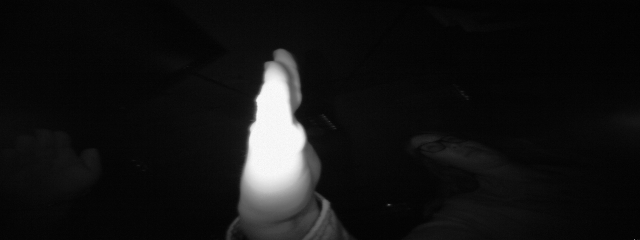

In [7]:
img_number = 156
img_sample = Image.open(images[img_number]).convert('L') # L - переводит в серый цвет
print(f"Shape: {np.array(img_sample).shape}")
print(f'Label: {labels[img_number]}')
print(label_names[img_number])

img_sample

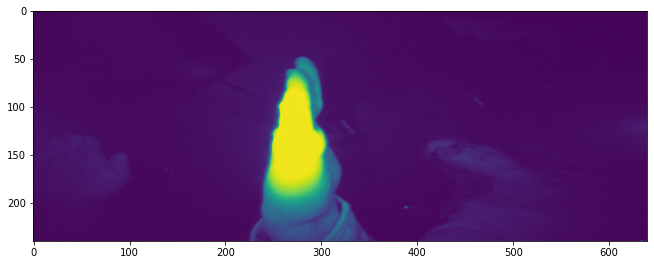

In [8]:
plt.figure(figsize=(11, 9))
plt.imshow(img_sample)

In [9]:
labels_set = set(label_names)
labels_set

{'01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down'}

In [10]:
def digit_to_classname(digit):
    if digit == 0:
        return 'palm'
    elif digit == 1:
        return 'l'
    elif digit == 2:
        return 'fist'
    elif digit == 3:
        return 'fist_moved'
    elif digit == 4:
        return 'thumb'
    elif digit == 5:
        return 'index'
    elif digit == 6:
        return 'ok'
    elif digit == 7:
        return 'palm_moved'
    elif digit == 8:
        return 'c'
    elif digit == 9:
        return 'down'

In [11]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки черно-белые
                         tt.Resize((52, 52)),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                        tt.Resize((52, 52)),
                        tt.ToTensor()])
# для теста делаем ресайз и переводим в тензор

In [12]:
from torch.utils.data import DataLoader, Dataset

class ImageWrapper(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        # img = Image.open(self._base_dataset[index])
        x = Image.open(self.images[index])
        y = self.labels[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y    

In [13]:
train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(images, labels, test_size=0.25, random_state=42)
len(train_imgs), len(train_lbls), len(test_imgs), len(test_lbls)

(15000, 15000, 5000, 5000)

In [14]:
train_dataset = ImageWrapper(train_imgs, train_lbls, train_tfms)
test_dataset = ImageWrapper(test_imgs, test_lbls, test_tfms)

In [15]:
batch_size = 128

In [16]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size, num_workers=1, shuffle=False)

In [17]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 52, 52])


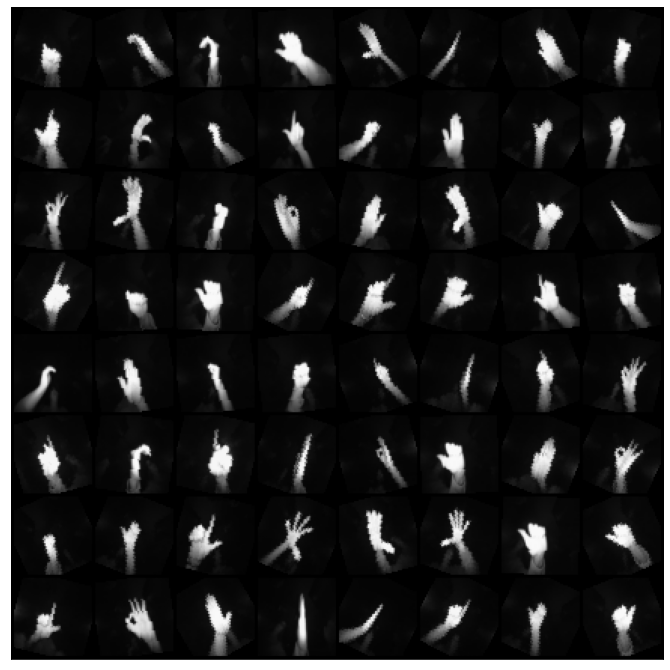

In [18]:
show_batch(train_dl)

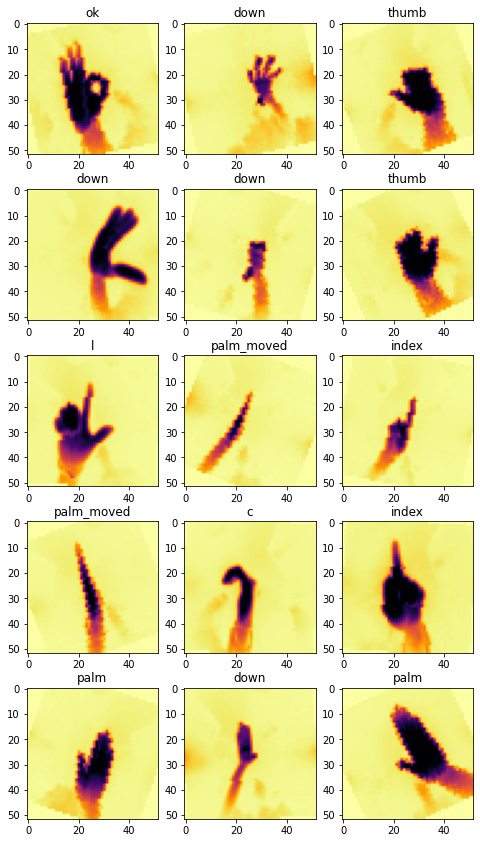

In [19]:
data_iter = iter(train_dl)

images, labels = next(data_iter)

plt.figure(figsize=(8, 27))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)    
    plt.imshow(images[i, 0, :, :], cmap='inferno_r')    
    plt.title(f'{digit_to_classname(labels[i])}')
    if i > 13:
        break

## Модель

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [21]:
model = ResNet(1, len(labels_set)).to(device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Обучение

In [22]:
epochs = 15
max_lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), max_lr)

epoch_losses = []
epoch_accs = []
epoch_test_losses = []
epoch_test_accs = []

for epoch in range(epochs):
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    epoch_loss = []    

    for batch_idx, (data, labels) in enumerate(train_dl):
        data = data.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        running_items += len(labels)        
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

    epoch_acc = running_right / running_items
    epoch_accs.append(epoch_acc.item())
    epoch_losses.append(np.mean(epoch_loss))
    

    test_running_loss = 0
    test_epoch_loss = []
    torch.cuda.empty_cache()
    
    # выводим статистику на тестовых данных
    test_running_right, test_running_total = 0.0, 0.0

    for batch_idx, (data, labels) in enumerate(test_dl):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        test_running_total += len(labels)        
        test_running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
    epoch_test_acc = test_running_right / test_running_total

    if epoch > 0 :        
        if epoch_test_acc.item() > max(epoch_test_accs):               
            torch.save(model, '/content/gest_prediction_model.pth')
            print("New model saved!")

    epoch_test_accs.append(epoch_test_acc.item())
    epoch_test_losses.append(np.mean(test_epoch_loss))

    print('\033[1m' + f'Epoch [{epoch + 1}/{epochs}]: ' + '\033[0m' \
          f'Train loss = {epoch_losses[-1]:.5f}  |  ' \
          f'Train accuracy = {epoch_accs[-1]*100:.3f}%  |  ' \
          f'Test loss = {epoch_test_losses[-1]:.3f}  |  ' \
          f'Test accuracy = {epoch_test_accs[-1]*100:.3f}%', sep='\n')

Epoch [1/15]: Train loss = 4.83840  |  Train accuracy = 21.693%  |  Test loss = 1.899  |  Test accuracy = 29.000%
New model saved!
Epoch [2/15]: Train loss = 2.07796  |  Train accuracy = 25.960%  |  Test loss = 1.737  |  Test accuracy = 31.880%
New model saved!
Epoch [3/15]: Train loss = 1.29392  |  Train accuracy = 54.413%  |  Test loss = 0.826  |  Test accuracy = 65.380%
New model saved!
Epoch [4/15]: Train loss = 0.51296  |  Train accuracy = 81.520%  |  Test loss = 0.364  |  Test accuracy = 87.320%
New model saved!
Epoch [5/15]: Train loss = 0.23183  |  Train accuracy = 92.107%  |  Test loss = 0.109  |  Test accuracy = 97.120%
Epoch [6/15]: Train loss = 0.12530  |  Train accuracy = 95.853%  |  Test loss = 0.083  |  Test accuracy = 96.580%
New model saved!
Epoch [7/15]: Train loss = 0.05684  |  Train accuracy = 98.253%  |  Test loss = 0.022  |  Test accuracy = 99.380%
Epoch [8/15]: Train loss = 0.11001  |  Train accuracy = 96.813%  |  Test loss = 0.020  |  Test accuracy = 99.300%
New

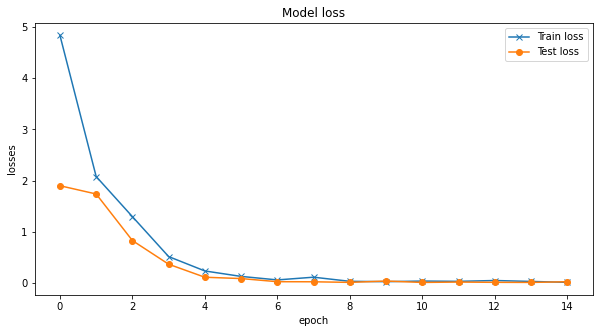

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, '-x', label='Train loss' )
plt.plot(epoch_test_losses, '-o', label='Test loss')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Model loss')
plt.legend()

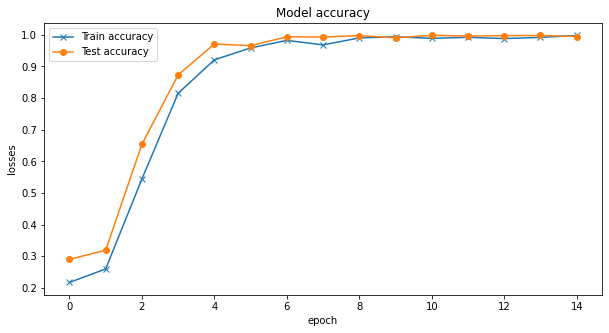

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_accs, '-x', label='Train accuracy' )
plt.plot(epoch_test_accs, '-o', label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Model accuracy')
plt.legend()

Модель с выбранными параметрами обучается где-то к 6-8 эпохе. Загрузим сохранённую модель и будем использовать.

In [25]:
net = torch.load('/content/gest_prediction_model.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Прогоним нашу нейронную сеть через тестовый датасет:

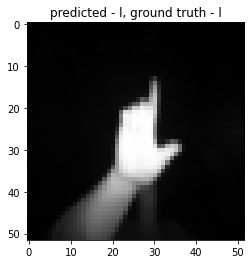

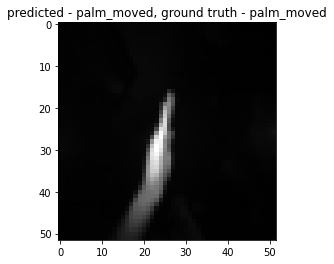

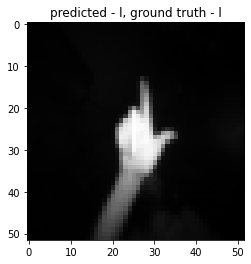

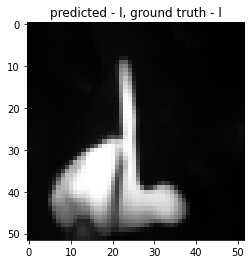

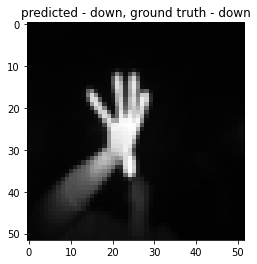

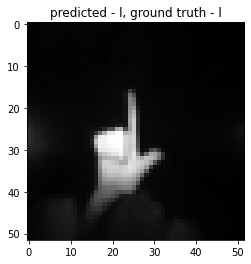

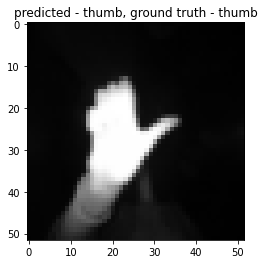

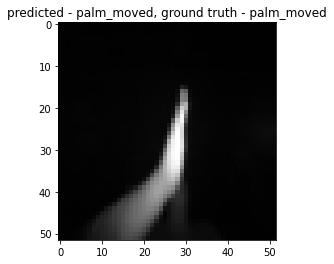

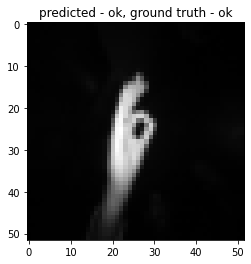

In [27]:
with torch.no_grad():
  for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        plt.title(f'predicted - {digit_to_classname(int(outputs[0].argmax().item()))}, ground truth - {digit_to_classname(int(labels[0]))}')        
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i > 10:
            break

Модель для классификации работает.

In [28]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00


Подключим встроенную камеру для получения фото

## Проверка камеры и распознавания жестов.

In [29]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [30]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Image saved to {}'.format(filename))
  
  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Image saved to photo.jpg


In [31]:
def predict_gesture():
  
    with torch.no_grad():
      img = take_photo()
      display(Image(img))
      img = cv2.imread(img)
      
      transform = tt.Compose([tt.ToPILImage(),
                              tt.Grayscale(num_output_channels=1),
                              tt.Resize((50, 50)),
                              tt.ToTensor()])
      img = transform(img).unsqueeze(1)
      outputs = net(img.to(device))
      print(f'predicted - {digit_to_classname(int(outputs[0].argmax().item()))}')

<IPython.core.display.Javascript object>

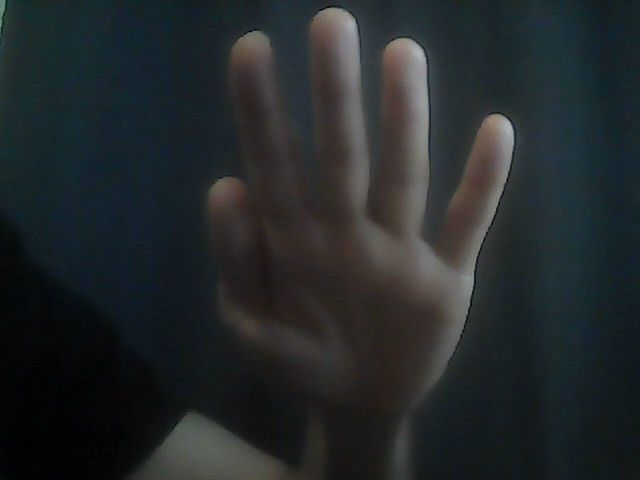

predicted - down


In [35]:
predict_gesture()     

## Реализация детекции по лицу и распознование жеста.

In [36]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow

# Создаем объект для считывания потока с веб-камеры. Возможно его в инит
# cap = cv2.VideoCapture(0)
# gestures = []

class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        # self.cap = cv2.VideoCapture(0)
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('/content/gest_prediction_model.pth')
        # self.emodel = torch.load('/content/gest_prediction_model.pth', map_location=torch.device('cpu'))
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, gestures):
        """
        Draw landmarks and boxes for each face detected
        """

        try:
            for box, prob, gesture in zip(boxes, probs, gestures):
                print(box, prob, gesture)
                # Draw rectangle on frame
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 155, 255), thickness=2)
                # Show probability. Пишем на рисунке какой жест   
                cv2.putText(frame, gestures[0], (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)

        except:
            print('Something wrong with drawing function!')
            pass

        return frame
    
    # Cropping faces function
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'palm'
        elif digit == 1:
            return 'l'
        elif digit == 2:
            return 'fist'
        elif digit == 3:
            return 'fist_moved'
        elif digit == 4:
            return 'thumb'
        elif digit == 5:
            return 'index'
        elif digit == 6:
            return 'ok'
        elif digit == 7:
            return 'palm_moved'
        elif digit == 8:
            return 'c'
        elif digit == 9:
            return 'down'

    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                

        while True:
            # success, frame = cap.read()
            # print(success)

            frame = cv2.imread(take_photo())

            try:                
                # detect face box, probability and landmarks
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                # print(probs)
                gestures = []
          
                if probs[0]:
                  transform = tt.Compose([tt.ToPILImage(),
                                  tt.Grayscale(num_output_channels=1),
                                  tt.Resize((50, 50)),
                                  tt.ToTensor()])
          
                  all_frame = transform(frame).unsqueeze(1)
                  gesture = self.emodel(all_frame.to(device))
                  gesture = self.digit_to_classname(gesture.argmax())                  
                  gestures.append(gesture)
                 
                  # draw on frame
                  self._draw(frame, boxes, probs, gestures)
                else:
                  print('We need face')

            except:
                  pass

            cv2_imshow(frame)


            if cv2.waitKey(0):
                break

        cv2.destroyAllWindows()

In [37]:
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)

<IPython.core.display.Javascript object>

[ 68.58218 128.8745  250.87302 347.74963] 0.9997162 ok


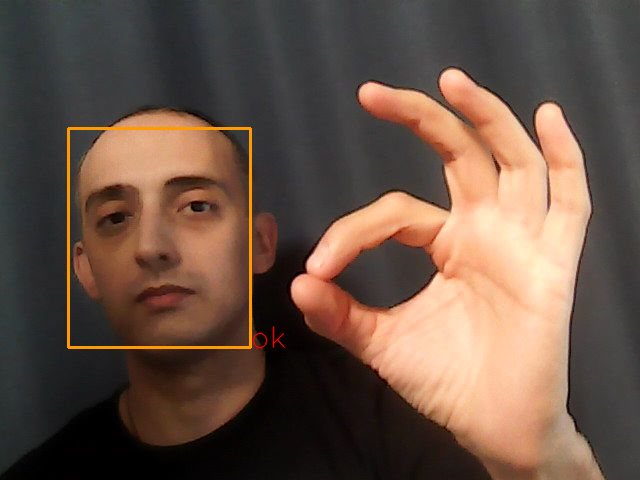

In [50]:
fcd.run()

Модель очень плохо классифицирует жест, когда с одновременной детекцией лица. Предположительно нужно как-то вырезать жест и подавать его на классификацию отдельно.